In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl

import pandas as pd
import geopandas as gpd

from scipy.cluster.hierarchy import linkage, cophenet
from scipy.spatial.distance import squareform
from skimage.filters import threshold_li, threshold_yen, threshold_otsu

from shapely.ops import Point, LineString
import contextily as ctx

import seaborn as sns
sns.set()

import oslo_lib
import CCC

In [24]:
trips_per_station=pd.read_pickle('Oslo/trips_per_station.pkl')
stations = pd.read_pickle('Oslo/stations.pkl')

stations = oslo_lib.get_geostations(stations)
stations_GPS = stations.geometry.apply(lambda x : [x.x, x.y]).to_list()
stations_distances = pd.read_pickle('Oslo/station_distances.pkl')

# Spatial clustering of stations

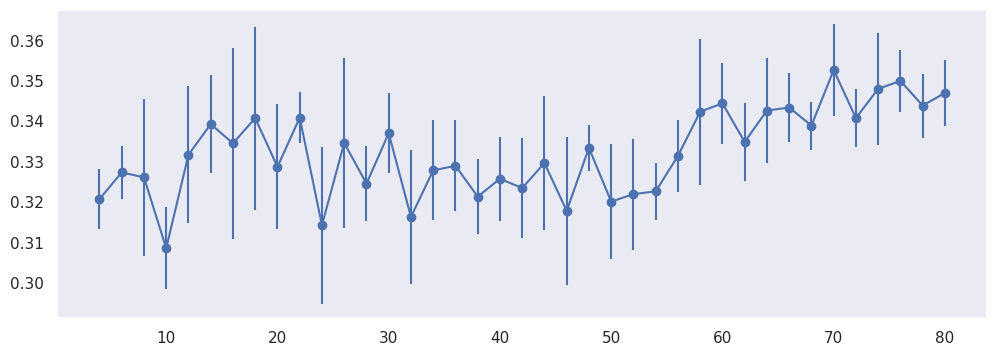

In [28]:
from sklearn.cluster import *
from sklearn import metrics
import numpy as np

df = trips_per_station.copy()
data = stations_GPS

cluster_range = range(4, 81, 2)
silhouettes = []
silhouettes_std = []

for n_clusters in cluster_range:
    sil = []
    for i in range(5):
        clustering = KMeans(n_clusters)
        labels = clustering.fit_predict(data, sample_weight = df.trip)
        sil.append(metrics.silhouette_score(data, labels, metric='euclidean'))
    silhouettes.append(np.mean(sil))
    silhouettes_std.append(np.std(sil))
# 18 and 50 seem like good choices

plt.figure(figsize=(12,4))
plt.errorbar(cluster_range, silhouettes, marker='o', yerr=silhouettes_std)
plt.grid()
plt.show()

50 clusters. Mean cluster size 5.66


<Axes: title={'center': 'cluster size distribution'}, xlabel='count'>

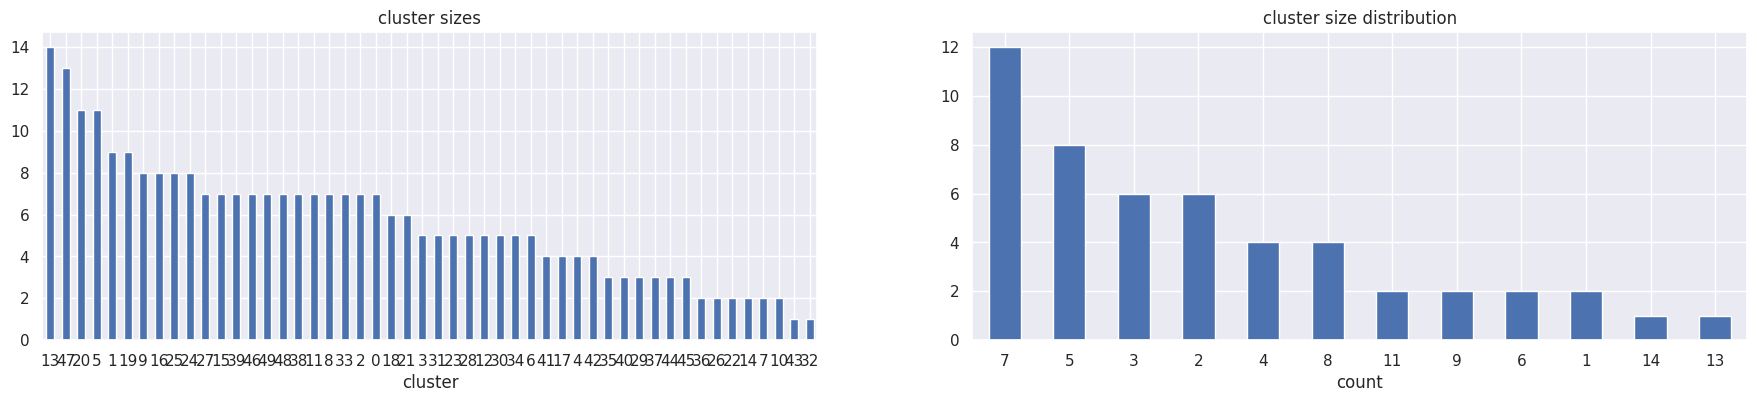

In [80]:
from sklearn.cluster import *
from sklearn.mixture import GaussianMixture

df = trips_per_station.copy()
data = stations_GPS

#clustering = DBSCAN(eps=.00003)
#clustering = OPTICS(min_samples=5)
#clustering = OPTICS(min_cluster_size=2, )
#clustering = GaussianMixture(50)

# Best choices:
clustering = KMeans(50)
#clustering = KMeans(18)
#clustering = AffinityPropagation()
#clustering = AgglomerativeClustering(8)

clustering.fit(data)

try:
    clustering.fit(data, sample_weight = df.trip)
except TypeError:
    print("no sample weight support")
    clustering.fit(stations_GPS)

try:
    labels = clustering.labels_
except AttributeError:
    labels = clustering.fit_predict(data)

df['cluster'] = labels
print(len(df.cluster.unique()), 'clusters. Mean cluster size', df.cluster.value_counts().mean())

fig, axes= plt.subplots(1,2, figsize=(22,4))
df.cluster.value_counts().plot.bar(rot=0, title='cluster sizes', ax=axes[0])
df.cluster.value_counts().value_counts().plot.bar(rot=0, title='cluster size distribution', ax=axes[1])

/tmp/ipykernel_45684/3745114477.py:11: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = t.plot(ax=ax, edgecolor='k', color='w', markersize=t.trip/size, alpha=.8)


(np.float64(-4202.34659634261),
 np.float64(5833.514453011717),
 np.float64(211023.8031749105),
 np.float64(217798.64968259912))

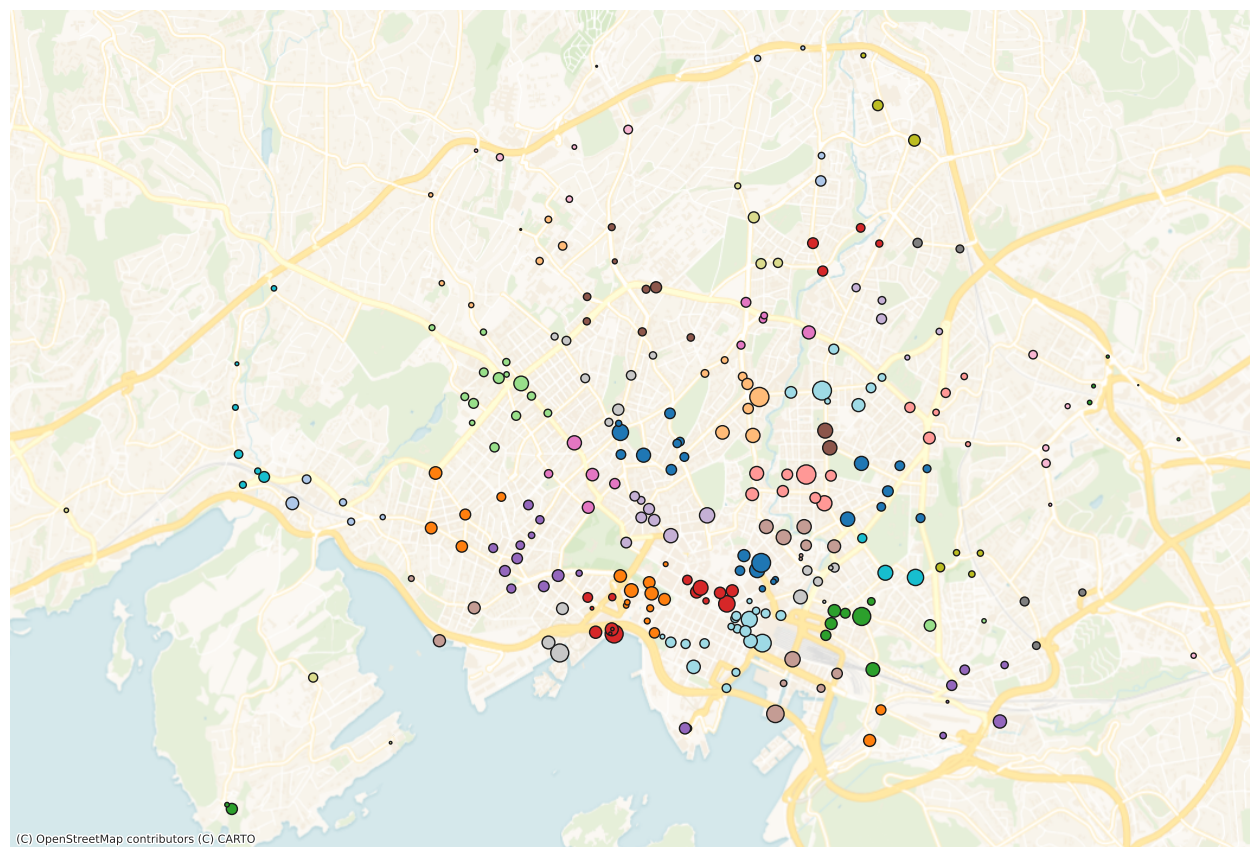

In [81]:
size=1000
threshold = 5 * 1e4
t = df.query('cluster>=0')
ax = t.plot(figsize=(16,16), 
            cmap='tab20',
            edgecolor='k',
            column='cluster',
            markersize=t.trip/size
           )
t = df.query('cluster<0')
ax = t.plot(ax=ax, edgecolor='k', color='w', markersize=t.trip/size, alpha=.8)
ctx.add_basemap(ax=ax, crs=trips_per_station.crs, source=ctx.providers.CartoDB.VoyagerNoLabels, zoom=13)

plt.axis('off')

In [82]:
try:
    cluster_centers = clustering.cluster_centers_
except:
    df['longitude_proj'] = df.geometry.apply(lambda x : x.x)
    df['latitude_proj'] = df.geometry.apply(lambda x : x.y)
    cluster_centers = df.groupby('cluster')[['longitude_proj', 'latitude_proj']].mean().values

In [83]:
cluster_centers = pd.DataFrame(cluster_centers, columns = ['cluster_lon', 'cluster_lat'])    
df = df.join(cluster_centers, on='cluster')
df[['cluster', 'cluster_lon', 'cluster_lat']].to_pickle('Oslo/stations_clusters.pkl')

# Tensor Factorization

## Getting the data

In [84]:
trips = pd.read_pickle('Oslo/processed_trips.pkl')
clusters = pd.read_pickle('Oslo/stations_clusters.pkl')
clusters_geo = clusters.drop_duplicates(['cluster']).set_index('cluster').sort_index()
stations['cluster'] = clusters.cluster

In [85]:
trips['geometry'] = trips_per_station.apply(lambda x : Point(x.longitude, x.latitude), axis=1)

In [86]:
data = trips.query('weekend == False and distance>0 and duration_min<=60 and year>=2021')
data = data.join(clusters.cluster.rename('start_cluster'), on='start_station_id')
data = data.join(clusters.cluster.rename('end_cluster'), on='end_station_id')

In [87]:
matrix = oslo_lib.get_matrix(data, clusters)

In [132]:
commuting_trips = trips.query("hour==6").groupby("start_station_id").end_station_id.value_counts().unstack().fillna(0).astype(int)
commuting_trips = commuting_trips.sort_index().sort_index(axis=1)

## Actual factorization

In [97]:
import tensorly as tl
from tensorly.metrics import RMSE
import importlib

importlib.reload(oslo_lib)
importlib.reload(CCC)

<module 'CCC' from '/home/emmanuel/Documents/code/bikesharing/Oslo/CCC.py'>

In [98]:
def get_RMSE_error_range(T, 
                         factorization, 
                         reconstruction_function, 
                         rank_range, 
                         nruns=1, 
                         debug=False, 
                         init='svd', 
                         bootstrap=False, 
                         frac=.8,
                         data=data
                        ):
    errors = []
    for rank in rank_range:    
        local_errors = []
        for run in range(nruns):
            if bootstrap:
                T_ = oslo_lib.bootstrap_T(matrix, frac, data, clusters)
            else:
                T_ = T
            factors = factorization(T_, rank=rank, init=init)
            reconstructed_tensor = reconstruction_function(factors)
            error = RMSE(T_, reconstructed_tensor)
            local_errors.append(error)
            if debug:
                print(error)
        errors.append(np.mean(local_errors))
        
    return rank_range, errors

In [99]:
T = oslo_lib.get_T(matrix)

In [100]:
k_range = range(1, 31)
init = 'svd'

thresholding says the elbow is at error =  46.7233687477787


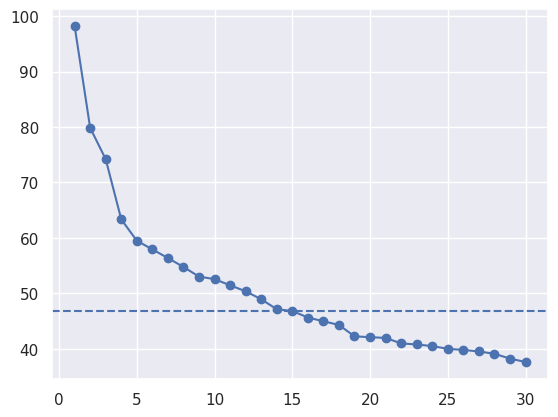

In [103]:
factorization, reconstruction_function = oslo_lib.get_factorization('parafac')
rank_range, errors = get_RMSE_error_range(T, factorization, reconstruction_function, k_range, 50, init=init, bootstrap=True)

threshold = threshold_yen(np.array(errors))
print('thresholding says the elbow is at error = ', threshold)

normalised_errors = [e/max(errors) for e in errors]

plt.plot(rank_range, errors, marker='o')
plt.axhline(threshold, ls='--')

### error analysis according to H and W

In [139]:
corr_coefs_H

[np.float64(nan),
 np.float64(0.922409690561633),
 np.float64(0.9174359441686115),
 np.float64(0.9056181602841957),
 np.float64(0.8867496088285922),
 np.float64(0.8849338722405186),
 np.float64(0.8658037185965788),
 np.float64(0.8450322124878067),
 np.float64(0.8211998897508029),
 np.float64(0.8048489427167786),
 np.float64(0.777828120737136),
 np.float64(0.7322979515064899),
 np.float64(0.7188732276742297),
 np.float64(0.703556640358819),
 np.float64(0.7033766600439331),
 np.float64(0.6973212168207004),
 np.float64(0.6841513041630282),
 np.float64(0.676433487404084),
 np.float64(0.689282407569171),
 np.float64(0.6932234382024527),
 np.float64(0.6840257889820197),
 np.float64(0.7241021118365174),
 np.float64(0.7976795596465895),
 np.float64(0.8503085396714705),
 np.float64(0.8076549576257812),
 np.float64(0.5276071334852618),
 np.float64(0.602232937481251),
 np.float64(0.5833305284430422),
 np.float64(0.6989883411879659),
 np.float64(0.6530368819453368)]

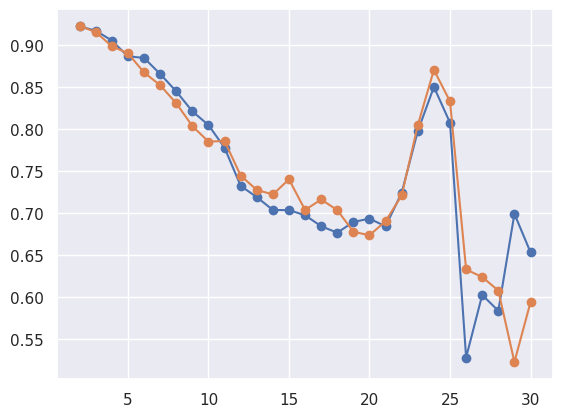

In [142]:
corr_coefs_W = [CCC.compute_rho(k, factorization, T, nruns=50, init=init, bootstrap=True, data=data, clusters=clusters, use_W=True) for k in k_range]
corr_coefs_H = [CCC.compute_rho(k, factorization, T, nruns=50, init=init, bootstrap=True, data=data, clusters=clusters, use_W=False) for k in k_range]
plt.plot(k_range, corr_coefs_H, marker='o')
plt.plot(k_range, corr_coefs_W, marker='o')

Text(0, 0.5, 'CCC according to H and W')

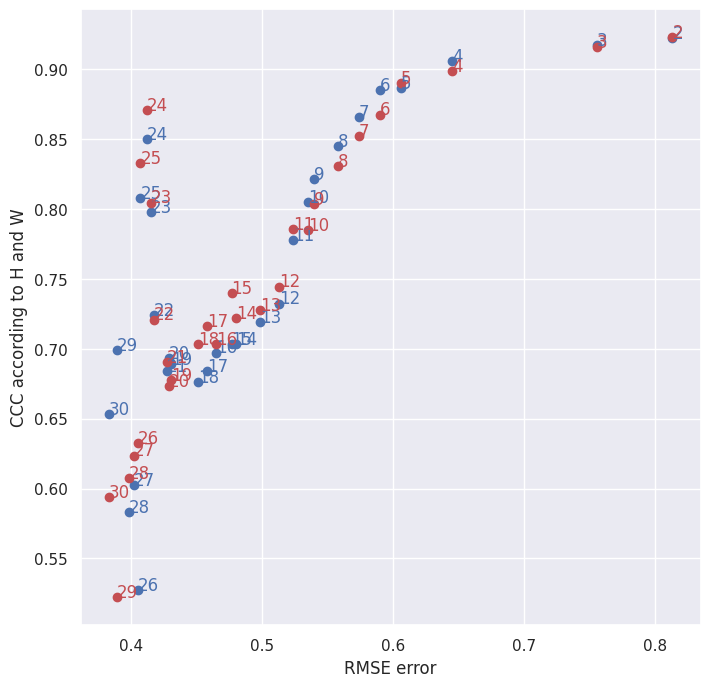

In [105]:
plt.figure(figsize=(8,8))

for c, CC in zip(['b', 'r'], [corr_coefs_H, corr_coefs_W]):
    plt.scatter(normalised_errors, CC, color=c)
    for i, ec in enumerate(zip(normalised_errors, CC)):
        plt.annotate(i+1, ec, color=c)
    
plt.xlabel('RMSE error')
plt.ylabel('CCC according to H and W')

RMSE  CCC_H  CCC_W  inv_CCC_H  inv_CCC_W  error_L2_H  error_L2_W  \
24  0.41   0.85   0.87       0.15       0.13        0.44        0.43   
25  0.41   0.81   0.83       0.19       0.17        0.45        0.44   
23  0.42   0.80   0.80       0.20       0.20        0.46        0.46   
22  0.42   0.72   0.72       0.28       0.28        0.50        0.50   
21  0.43   0.68   0.69       0.32       0.31        0.53        0.53   

    error_L2_global  
24             0.62  
25             0.63  
23             0.65  
22             0.71  
21             0.75

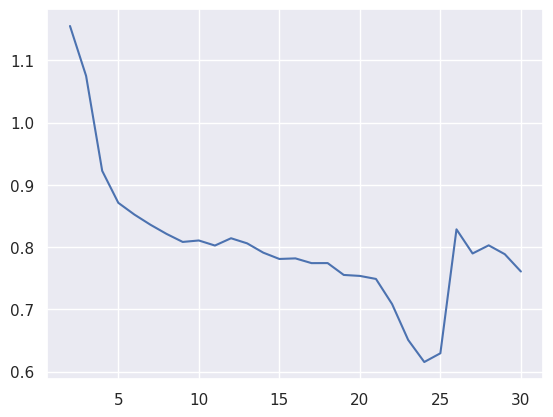

In [106]:
def L2(x):
    return sum([e**2 for e in x])**.5


df_errors = pd.DataFrame({'RMSE':normalised_errors, 'CCC_H':corr_coefs_H, 'CCC_W':corr_coefs_W}, index=k_range)

df_errors['inv_CCC_H'] = 1 - df_errors['CCC_H']
df_errors['inv_CCC_W'] = 1 - df_errors['CCC_W']

df_errors['error_L2_H'] = df_errors[['RMSE', 'inv_CCC_H']].apply(L2, axis=1)
df_errors['error_L2_W'] = df_errors[['RMSE', 'inv_CCC_W']].apply(L2, axis=1)
df_errors['error_L2_global'] = df_errors[['error_L2_H', 'error_L2_W']].apply(L2, axis=1)

# index is the number of clusters.
df_errors.sort_values(by='error_L2_global', inplace=True)
df_errors.sort_index().error_L2_global.plot()
df_errors.round(2).head()

Text(0, 0.5, 'L2 error according to W matrix')

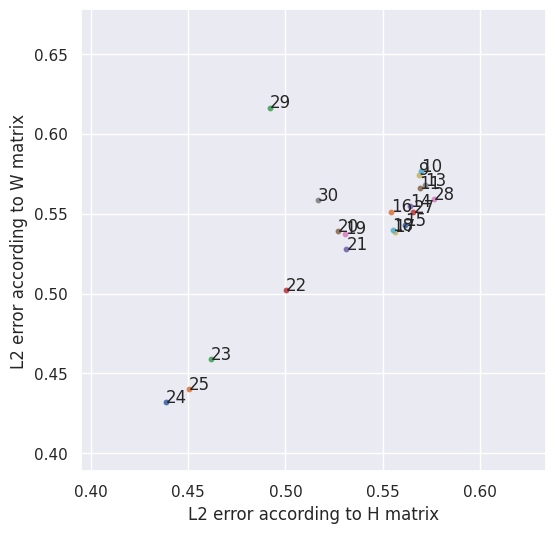

In [107]:
values = [*df_errors[['error_L2_H', 'error_L2_W']].dropna().itertuples()]
values = values[:20]

fig, ax = plt.subplots(figsize=(6, 6))
for v in values:
    ax.scatter(v[1], v[2], s=10)
    ax.annotate(v[0], v[1:])

ax.set_xlim(.9*min([v[1] for v in values]), max([v[1] for v in values])*1.1)
ax.set_ylim(.9*min([v[2] for v in values]), max([v[2] for v in values])*1.1)

ax.set_xlabel('L2 error according to H matrix')
ax.set_ylabel('L2 error according to W matrix')

### Factorize

In [108]:
# According to the above analysis, 17, 16 and 10 appear like good candidates
n_components = 24

temporal_factors, W, H = factorization(T, rank=n_components, init='svd').factors

try:
    core = factorization.core
except AttributeError:
    core = None

trips_in_components = [np.outer(np.outer(w, h), t).sum() for w,h,t in zip(W.T, H.T, temporal_factors.T)]

## Exploring factors

In [111]:
factors = pd.DataFrame()
for n in range(n_components):
    X_ = np.outer(W.T[n], H.T[n])
    factor = pd.DataFrame(X_, 
             index=matrix.loc[0].index.rename('start_cluster'), 
             columns=matrix.loc[0].index.rename('end_cluster'))
    factor = factor.stack().rename('trips').reset_index()
    factor['component'] = n
    factors = pd.concat([factors, factor])

full_factor = factors.groupby(['start_cluster', 'end_cluster', 'component']).trips.sum().unstack().sum(axis=1).rename('trips').reset_index()
full_factor['component'] = 'full'
factors = pd.concat([factors, full_factor])
    
factors = factors.join(clusters_geo[['cluster_lat', 'cluster_lon']].add_prefix('start_'), on='start_cluster')
factors = factors.join(clusters_geo[['cluster_lat', 'cluster_lon']].add_prefix('end_'), on='end_cluster')

factors['start_point'] = factors.apply(lambda x : Point(x.start_cluster_lon, x.start_cluster_lat), axis=1)
factors['end_point'] = factors.apply(lambda x : Point(x.end_cluster_lon, x.end_cluster_lat), axis=1)
factors['geometry'] = factors.apply(lambda x : LineString([x.start_point, x.end_point]), axis=1)
factors = gpd.GeoDataFrame(factors)
factors = factors.set_crs(stations.crs)

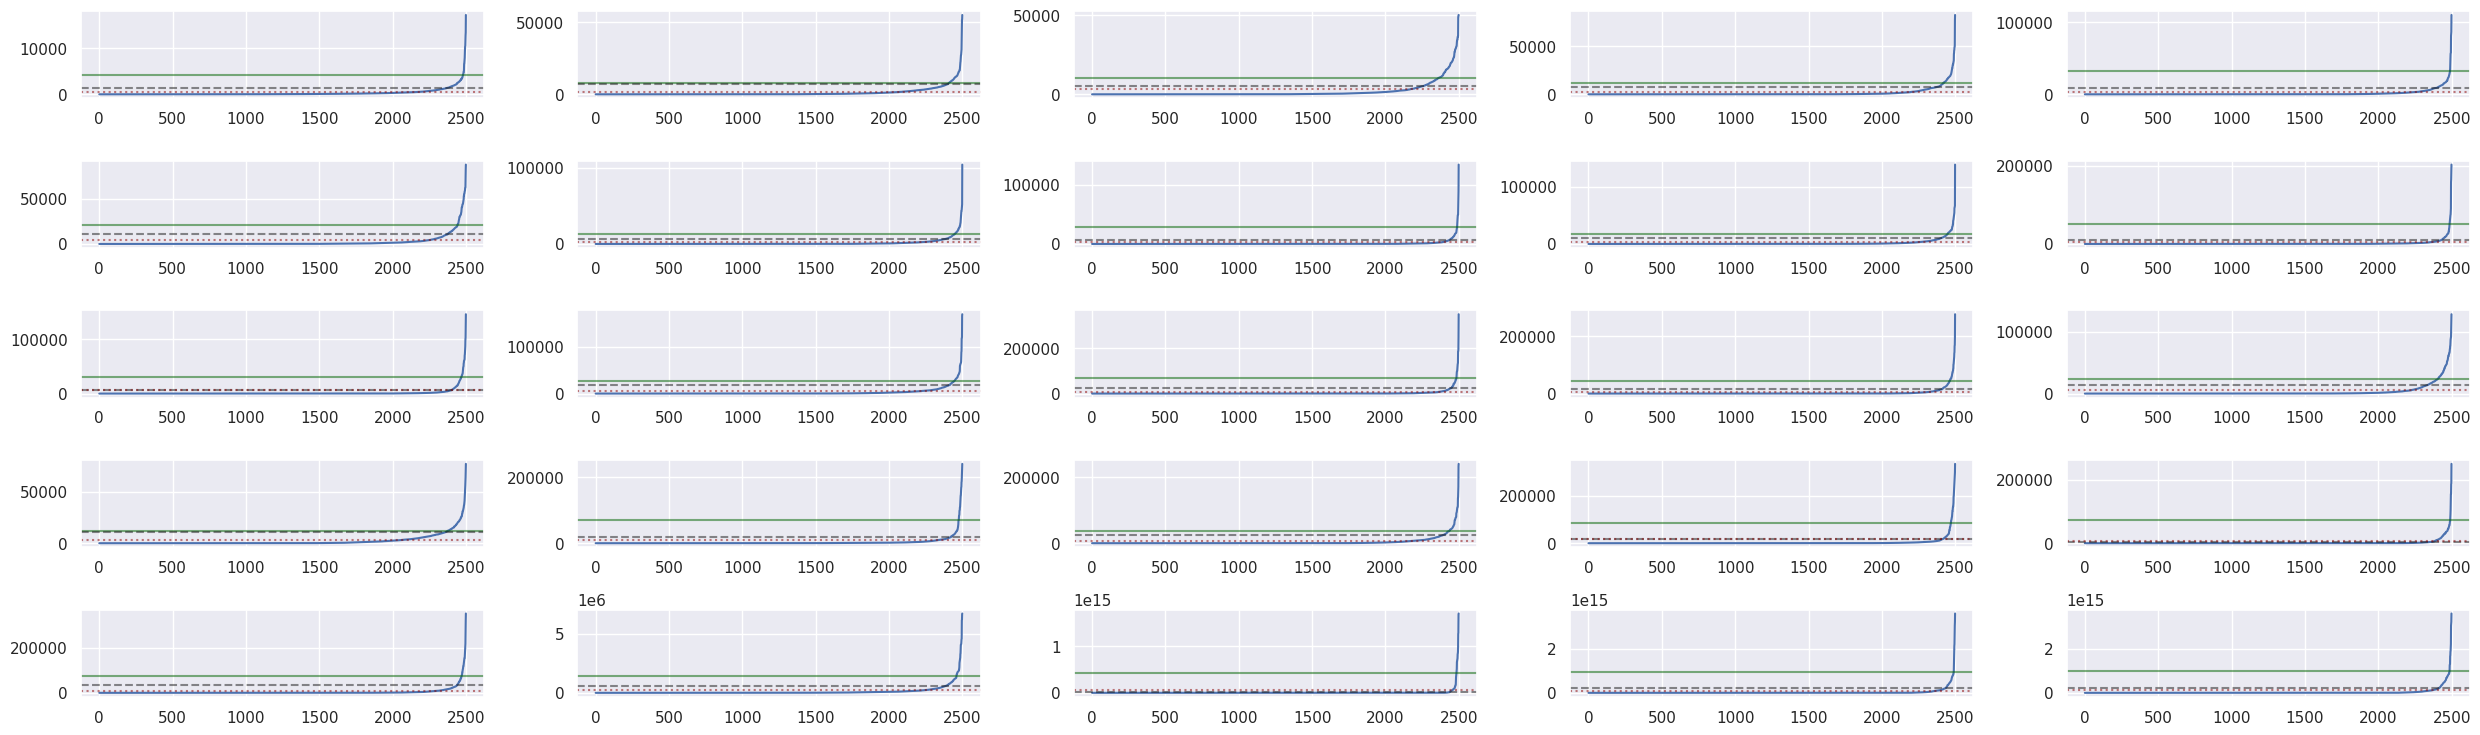

In [112]:
factors_unstacked = factors[['component', 'trips']].reset_index().pivot_table(index='index', columns='component', values='trips')

n_col = int(np.sqrt(len(factors_unstacked.columns)))
n_rows = int(np.ceil(len(factors_unstacked.columns)/n_col))
fig, axes = plt.subplots(n_col, n_rows, figsize=(5 * n_col,1.5*n_rows))
axes=axes.flatten()

for e, ax in zip(factors_unstacked.values.T, axes):
    ax.plot(sorted(e))
    ax.axhline(threshold_otsu(e), ls='-', color='darkgreen', alpha=.5)
    ax.axhline(threshold_yen(e), ls='--', color='k', alpha=.5)
    ax.axhline(threshold_li(e), ls=':', color='darkred', alpha=.5)

plt.tight_layout()

In [113]:
top_trips =  None # takes precedence
q_thresh = .99
threshold_function = threshold_yen

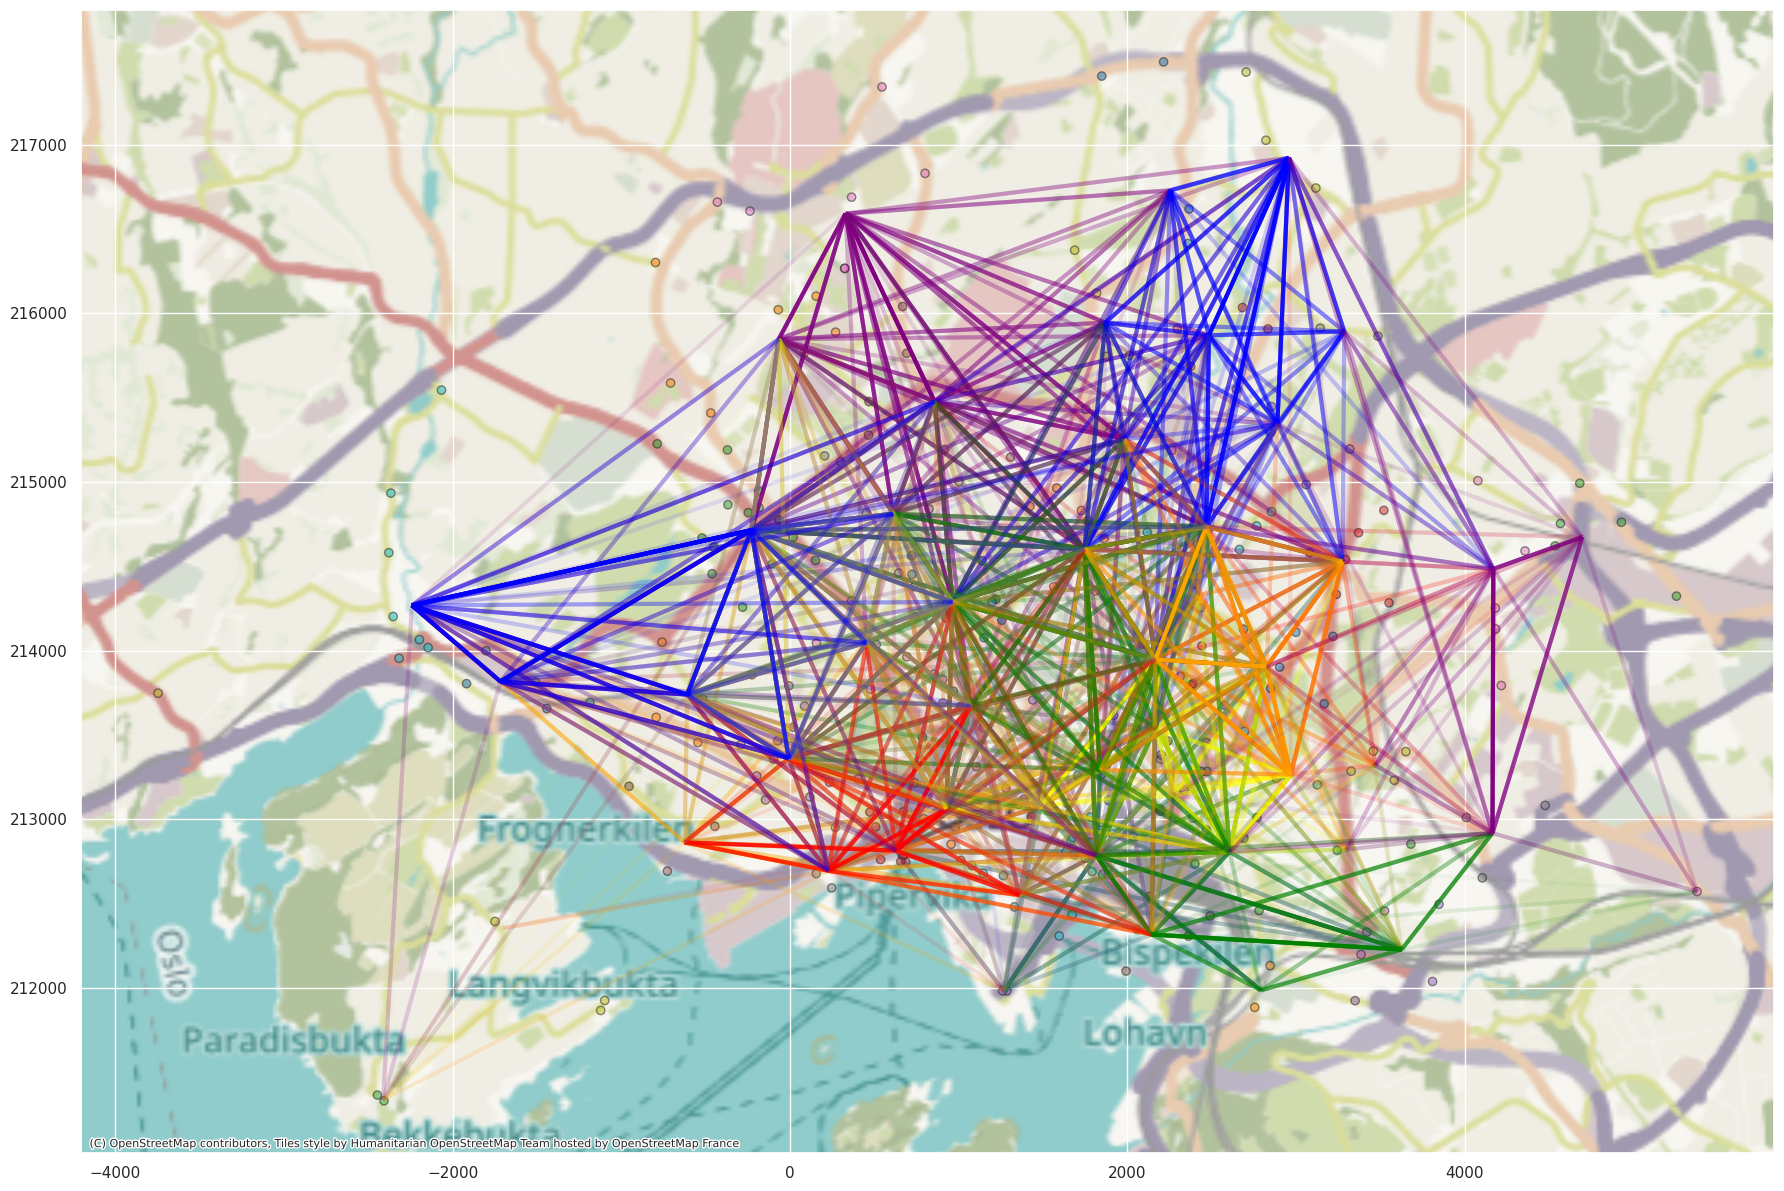

In [114]:
from itertools import cycle

def cycle_colors(colors = ['Blue', 'Green', 'Purple', 'Orange', 'Red', 'Yellow', 'Grey'], make_cmaps=False):
    if make_cmaps:
        yield from cycle([c+'s' for c in colors if c!='Yellow'])
    else:
        yield from cycle(colors)

fig, ax = plt.subplots(figsize=(18,18))

for component, cmap in zip(range(n_components), cycle_colors()):
    f = factors.query(f'component=={component}')
    
    f = oslo_lib.filter_f(f, top_trips, threshold_yen, q_thresh)

    alphas = (f.trips/1000)#.apply(np.log)
    alphas = alphas / alphas.max()
    alphas.fillna(0, inplace=True)
    
    f.plot(ax=ax,
           color=cmap,
           alpha=alphas,
           lw=3,
          )

stations.plot(ax=ax, column='cluster', edgecolor='k', cmap='tab10', alpha=.5)
ctx.add_basemap(ax, crs=factors.crs)    

plt.tight_layout()

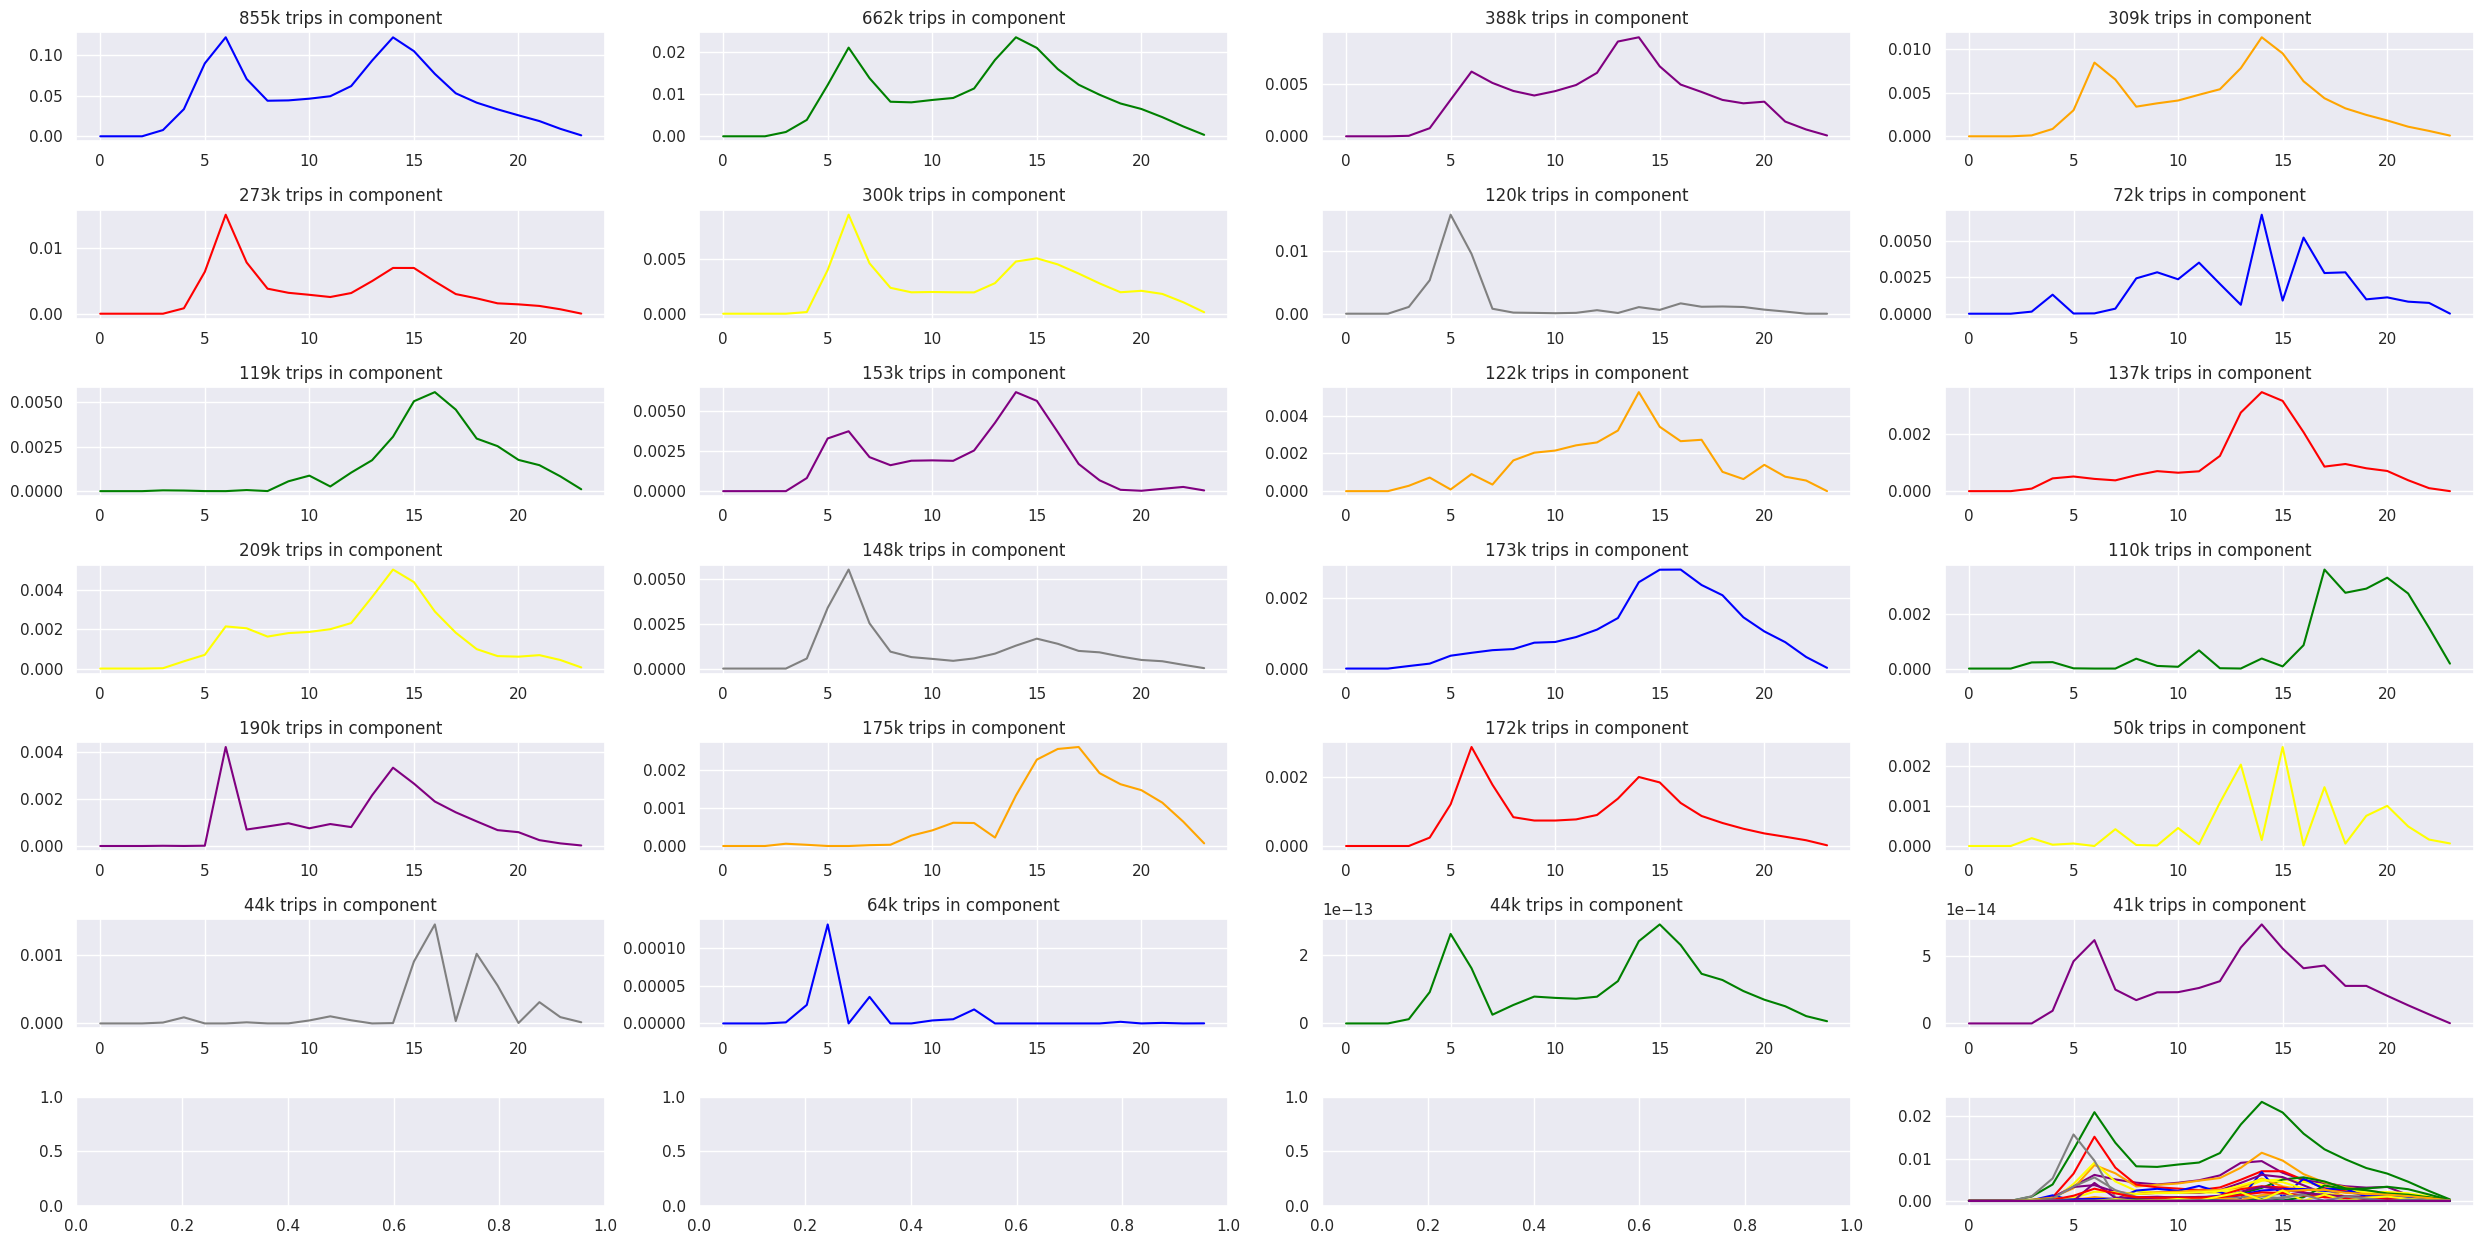

In [116]:
n_rows = int(np.ceil(np.sqrt(len(temporal_factors.T))))+1
n_cols = int(np.ceil(len(temporal_factors.T)/n_rows))
if n_rows * n_cols == len(temporal_factors.T):
    n_rows+=1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_col,1.8*n_rows))

axes = axes.flatten()
ct = 0
for ax, t, n_trips, color in zip(axes, temporal_factors.T, trips_in_components, cycle_colors()):
    ax.plot(t, c=color)
    ax.set_title(f'{int(n_trips/1000)}k trips in component')
    if ct!=0:
        axes[-1].plot(t, c=color)
    ct+=1

plt.tight_layout()

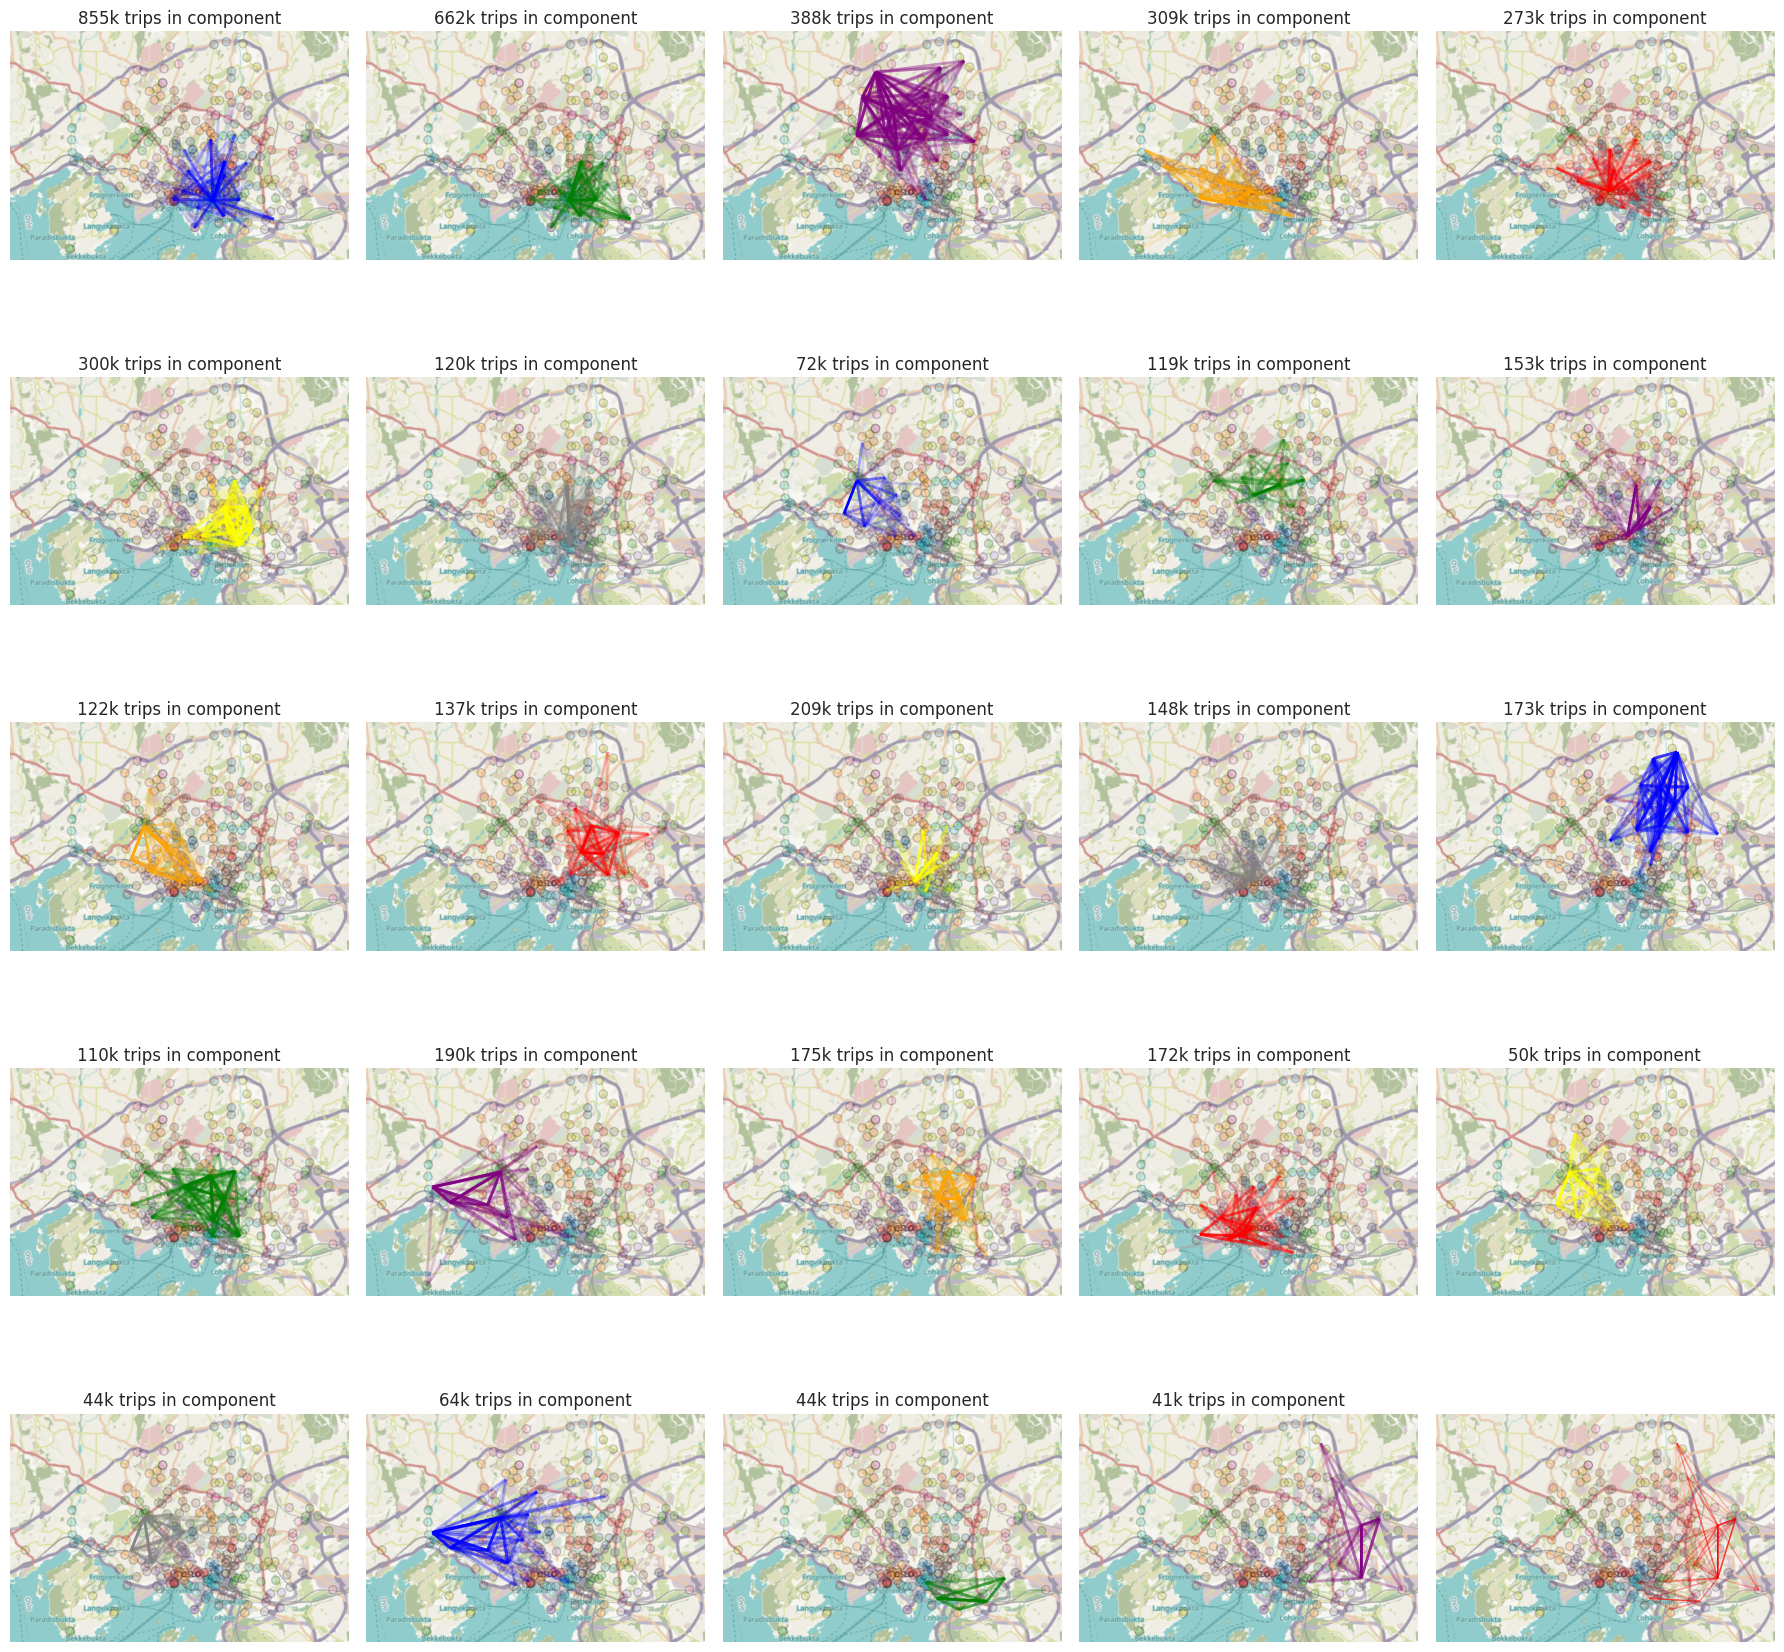

In [117]:
n_cols = int(np.round(np.sqrt(n_components)))
n_rows = int(np.ceil((n_components+1) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18,18))

n_components_to_plot = n_components
#n_components_to_plot = 10

for ax, component, n_trips, color in zip(axes.flatten(), range(n_components_to_plot), trips_in_components, cycle_colors()):
    f = factors.query(f'component=={component}')
    f = oslo_lib.filter_f(f, top_trips, threshold_yen, q_thresh)
    
    alphas = (f.trips/1000)#.apply(np.log)
    alphas = alphas / alphas.max()
    alphas.fillna(0, inplace=True)
    
    f.plot(ax=ax,
           color=color,
           alpha=alphas,
           lw=2,
          )
    ax.set_title(f'{int(n_trips/1000)}k trips in component')


ax=axes.flatten()[-1]

f = factors[factors.trips > threshold].query(f'component=="full"')
alphas = (f.trips/1000)#.apply(np.log)
alphas = alphas / alphas.max()
alphas.fillna(0, inplace=True)

f.plot(ax=ax,
       color='Red',
       alpha=alphas,
       lw=1,
      )

for ax in axes.flatten():
    stations.plot(ax=ax, column='cluster', edgecolor='k', cmap='tab10', alpha=.2)`
    ctx.add_basemap(ax, crs=factors.crs, attribution=False)
    ax.axis('off')

plt.tight_layout()

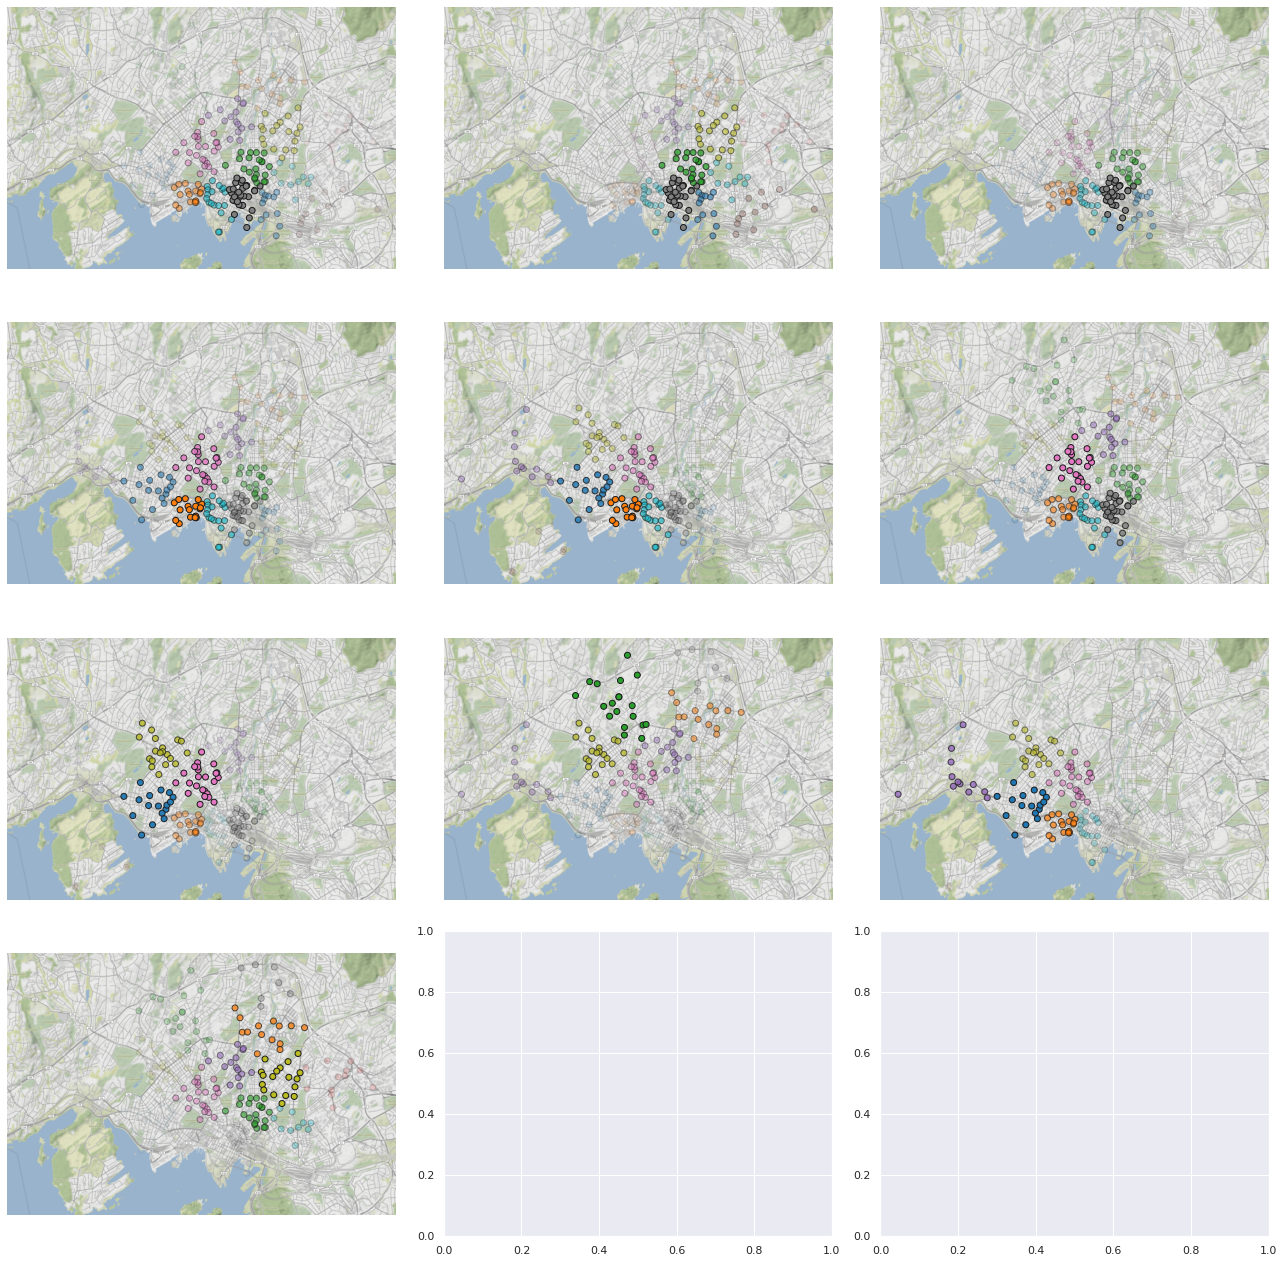

In [631]:
n_cols = int(np.round(np.sqrt(n_components)))
n_rows = int(np.ceil((n_components+1) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18,18))

for ax, component, n_trips, color in zip(axes.flatten(), range(n_components), trips_in_components, cycle_colors()):
    start = factors.query(f'component=={component}').groupby(['start_cluster']).trips.sum()
    end = factors.query(f'component=={component}').groupby(['end_cluster']).trips.sum()
    s = stations.join(start + end, on='cluster')
    s.plot(column='cluster', cmap='tab10', alpha=s.trips/s.trips.max(), edgecolor= 'k', ax=ax)
    ctx.add_basemap(ax=ax, crs=s.crs, attribution=False)
    ax.axis('off')
plt.tight_layout()